# Exploratory Data Analysis

In [1]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
import dash
from dash import dcc, html, Input, Output
import plotly.graph_objs as go

import sys
from pathlib import Path

# Example import
from src.utils import load_dataset, adf_test
from src.visualizations import (
    plot_open_close,
    plot_daily_returns,
    plot_rolling_stats,
    plot_correlation,
    plot_autocorrelation,
    plot_seasonality,
    get_volatility_returns_figure, 
    get_moving_averages_figure, 
    get_candlestick_figure, 
    get_acf_pacf_figure
)

In [ ]:
DF_PATH = os.path.join("data","sp500_dates.csv")
DS_NAME = 'sp500'

## Utility functions ##

In [18]:
def run_volatility_app(open_, close_):
    daily_returns_close = close_.pct_change()
    daily_returns_open = open_.pct_change()
    
    app = dash.Dash(__name__)
    
    app.layout = html.Div([
        html.H2("Volatility & Returns Analysis"),
        html.Label("Select Sliding Window Size:"),
        dcc.Slider(
            id='sliding-window-slider',
            min=1,
            max=30,
            step=1,
            marks={i: str(i) for i in [2, 3, 4, 5, 10, 15, 30]},
            value=5,
        ),
        dcc.Graph(id='volatility-returns-plot')
    ])
    
    @app.callback(
        Output('volatility-returns-plot', 'figure'),
        [Input('sliding-window-slider', 'value')]
    )
    def update_graphs(sliding_window_size):
        return get_volatility_returns_figure(open_, close_, sliding_window_size)
    
    app.run(debug=False)


def run_moving_averages_app(open_, close_):
    app = dash.Dash(__name__)
    app.title = 'Moving Averages Dashboard'
    
    app.layout = html.Div([
        html.H1("Interactive SMA & EMA Chart", style={'textAlign': 'center'}),
        html.Label("Sliding Window Size:", style={'marginTop': 20}),
        dcc.Slider(
            id='window-slider',
            min=5,
            max=50,
            step=1,
            value=20,
            marks={i: str(i) for i in range(5, 55, 5)},
            tooltip={"placement": "bottom", "always_visible": True},
        ),
        dcc.Graph(id='ma-graph', style={'marginTop': 30})
    ], style={'width': '90%', 'margin': 'auto'})
    
    @app.callback(
        Output('ma-graph', 'figure'),
        Input('window-slider', 'value')
    )
    def update_chart(sliding_window_size):
        return get_moving_averages_figure(open_, close_, sliding_window_size)
    
    app.run(debug=False)


def run_candlestick_app(open_, high_, low_, close_, ds_name):
    app = dash.Dash(__name__)
    fig = get_candlestick_figure(open_, high_, low_, close_, ds_name)
    
    app.layout = html.Div([
        html.H1(f"{ds_name} Candlestick Chart", style={'textAlign': 'center'}),
        dcc.Graph(figure=fig)
    ])
    
    app.run(debug=False)

## Load and Inspect Data ##

**_Dataset Description:_**  
The dataset used in this notebook consists of historical stock data from the S&P 500 index, retrieved using the [`yfinance`](https://pypi.org/project/yfinance/) library. The S&P 500 is a market-capitalization-weighted index of 500 of the largest publicly traded companies in the United States, representing a broad snapshot of the U.S. equity market.

Using `yfinance`, we are able to access time series data for individual tickers within the S&P 500, including daily **Open**, **High**, **Low**, **Close**, **Adj Close**, and **Volume** values. 

Each daily record includes:
- **Open**: The price of the stock at the start of the trading day.
- **High**: The highest price the stock reached during the trading day.
- **Low**: The lowest price the stock reached during the trading day.
- **Close**: The final price of the stock when the market closed for that day.
- **Volume**: The total number of shares traded during the day, providing insight into market activity and liquidity.

This dataset was introduced to me by the professor when we were first introduced to the topic of time series forecasting in the context of finance. I found it to be a well-structured and high-quality dataset that is well-suited for experimentation and comparison between different forecasting methods.

In [4]:
df = load_dataset(DF_PATH)

,Open,High,Low,Close,Volume
Date,,,,,
2001-01-02,1320.280029,1320.280029,1276.050049,1283.270020,1129400000
2001-01-03,1283.270020,1347.760010,1274.619995,1347.560059,1880700000
2001-01-04,1347.560059,1350.239990,1329.140015,1333.339966,2131000000
2001-01-05,1333.339966,1334.770020,1294.949951,1298.349976,1430800000
2001-01-08,1298.349976,1298.349976,1276.290039,1295.859985,1115500000
...,...,...,...,...,...
2008-12-23,874.309998,880.440002,860.099976,863.159973,4051970000
2008-12-24,863.869995,869.789978,861.440002,868.150024,1546550000
2008-12-26,869.510010,873.739990,866.520020,872.799988,1880050000


Key characteristics of the dataset:
- **Frequency**: Daily observations, excluding weekends and public holidays (when the stock market is closed). To maintain a continuous daily time series—which is required by the models selected for this project—**an interpolation technique was applied to fill in the missing dates with estimated values**. This ensures that the input data has a **consistent daily frequency**, even on non-trading days.
- **Features**: Price and volume indicators for each trading day.
- **Coverage**: Depends on the selected ticker(s) and the time range specified; typically spans multiple years. TODO: update
- **Source**: Yahoo Finance, accessed via the `yfinance` API.

## Candlestick Plot ##

What it is:
A candlestick chart showing Open, High, Low, and Close prices per time period.

Why it matters:
Provides detailed price action and investor sentiment signals within each time period.

What to observe:

Patterns like Doji, Hammer, Engulfing which suggest reversals or continuations

Length of wicks indicating intraday volatility or rejection levels

Color patterns to infer bullish or bearish sentiment

Hypotheses:

Specific candlestick patterns may precede trend reversals

Long lower wick might indicate buying pressure

Consecutive bullish candles may confirm momentum

In [9]:
run_candlestick_app(df['Open'], df['High'], df['Low'], df['Close'], DS_NAME)

## Summary Stats ##

In [10]:
df.describe()

,Open,High,Low,Close,Volume
count,2010.000000,2010.000000,2010.000000,2010.000000,2.010000e+03
mean,1187.474553,1195.450877,1178.652866,1187.302095,2.257390e+09
std,180.326713,179.563836,181.296274,180.433599,1.379745e+09
min,755.840027,798.549988,741.020020,752.440002,3.560700e+08
25%,1084.077454,1091.872528,1075.594971,1083.882446,1.359225e+09
50%,1190.229980,1195.979980,1183.635010,1190.229980,1.693850e+09
75%,1304.137512,1311.609985,1295.272522,1304.324982,2.696278e+09
max,1564.979980,1576.089966,1555.459961,1565.150024,1.145623e+10


## ADF Test for Stationarity ##

This function adf_test performs the Augmented Dickey-Fuller (ADF) test, which is a statistical test used to check if a time series is stationary.

Step-by-step explanation:
Input:

series: The time series data you want to test (like your stock prices or returns).

label: A string label for your series, just to print out a nice message.

What it does:

Calls adfuller(series, autolag='AIC') from statsmodels.tsa.stattools, which runs the ADF test.

The ADF test checks whether your time series has a unit root, which implies it is non-stationary (meaning its statistical properties like mean and variance change over time).

Outputs:

Prints several key statistics:

ADF Statistic: The test statistic value (more negative values indicate stronger evidence against non-stationarity).

p-value: Probability value to decide whether to reject the null hypothesis.

# Lags Used: Number of lag observations included in the test.

Number of Observations Used: The effective sample size used for the test.

Uses the p-value to decide:

If p-value <= 0.05, print "Series is stationary" (reject null hypothesis: no unit root).

Else, print "Series is NOT stationary" (fail to reject null hypothesis: unit root present, non-stationary).

Why is this important?
Many time series models (like ARIMA) assume stationarity for reliable forecasting.

Stationarity means the series has constant mean and variance over time — easier to model.

If the series is non-stationary, you might need to difference it or transform it before modeling.

In [11]:
adf_test(df['Open'], 'Open')
adf_test(df['Close'], 'Close')


ADF Test on Open
ADF Statistic : -1.381864299649568
p-value : 0.5909390608462853
# Lags Used : 22
Number of Observations Used : 1987
=> Series is NOT stationary

ADF Test on Close
ADF Statistic : -1.4182762809056553
p-value : 0.5734835580836791
# Lags Used : 22
Number of Observations Used : 1987
=> Series is NOT stationary


## Daily Returns ##

plot_daily_returns
What it is:
A plot of daily returns, calculated as the percentage change from one day’s Close price to the next.

Why it matters:
Daily returns measure the day-to-day performance and are crucial for risk and volatility analysis.

What to observe:

Distribution and magnitude of returns (normality, skewness)

Presence of outliers or extreme returns

Clusters of positive or negative returns indicating momentum or crashes

Hypotheses:

Returns clustering might indicate trending periods

Large negative returns might precede volatility spikes or trend reversals

Consistent positive returns might indicate a bullish market

visualize_volatility_and_returns
What it is:
Plots measuring volatility (e.g., rolling standard deviation of returns) alongside returns.

Why it matters:
Volatility is a proxy for risk and market uncertainty. Understanding volatility alongside returns helps gauge the stability of price movements.

What to observe:

Periods of high volatility that might signal market stress

Relationship between volatility spikes and returns (e.g., do large returns precede volatility or vice versa)

Volatility clustering (volatility tends to cluster in time series)

Hypotheses:

High volatility periods may predict less reliable forecasts

Volatility tends to increase after large shocks (leverage effect)

Models need to adjust for volatility regime changes for better accuracy



In [19]:
run_volatility_app(df['Open'], df['Close'])

## Rolling Stats (Moving Average & STD) ##

What it is:
Plots rolling (moving) statistics such as rolling mean and rolling standard deviation.

Why it matters:
Rolling stats help visualize non-stationarity — changing mean or variance over time.

What to observe:

Whether rolling mean stabilizes (stationarity in mean)

Changes in rolling std indicating volatility shifts

Trends or regime changes in mean/variance

Hypotheses:

If rolling mean/variance change, model needs differencing or variance stabilization

Volatility clustering may be evident in rolling std spikes

Stationarity assumptions critical for statistical models like ARIMA



In [14]:
run_moving_averages_app(df['Open'], df['Close'])

## Correlation between Open and Close ##

What it is:
Correlation heatmap or scatter plot between Open, Close, Returns, or other features.

Why it matters:
Shows linear relationships between variables that may inform feature selection or engineering.

What to observe:

High correlation between Open and Close (expected)

Correlation of returns with volatility or other features

Identify redundant or complementary predictors

Hypotheses:

Strong correlation means one variable can predict the other well

Weak correlation suggests more complex, nonlinear relations

Can help decide what features to include in models

Correlation between Open and Close: 1.00
Correlation between Open and Close: 1.00


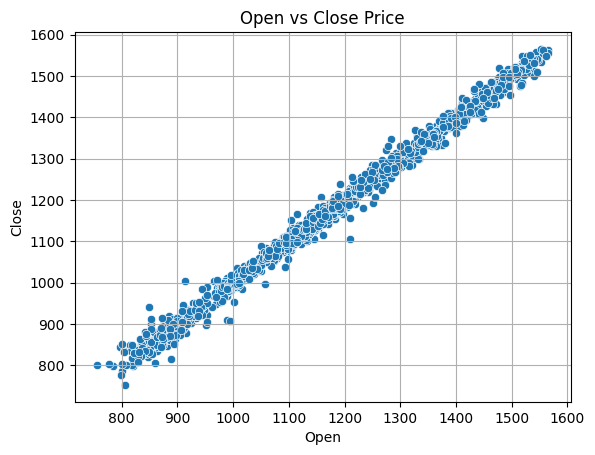

In [15]:
correlation = df['Open'].corr(df['Close'])
print(f"Correlation between Open and Close: {correlation:.2f}")
plot_correlation(df)

## Autocorrelation ##

What it is:
Plots the autocorrelation function (ACF) showing correlation of the time series with its own lagged values.

Why it matters:
Autocorrelation measures persistence or memory in the series — key for time series forecasting.

What to observe:

Significant correlations at certain lags (daily, weekly)

Decay rate of autocorrelation over time

Presence of seasonality indicated by repeated peaks

Hypotheses:

Strong autocorrelation at lag 1 implies yesterday’s price influences today’s

Seasonal patterns appear as spikes at periodic lags

Low autocorrelation might suggest noise or lack of predictability

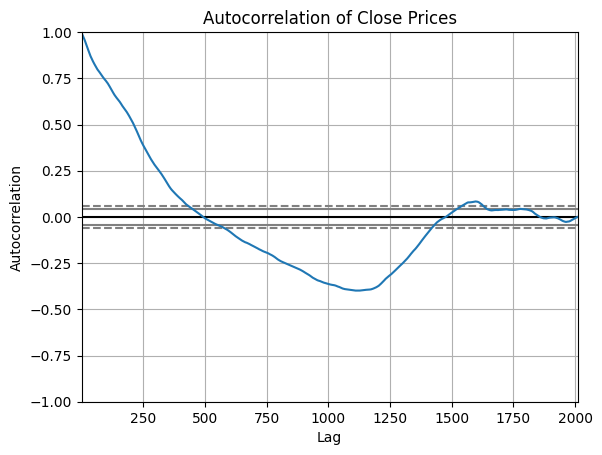

In [16]:
plot_autocorrelation(df)

## Seasonality Check - Weekly and Monthly Avg ##

What it is:
Plots showing seasonal patterns, e.g., average monthly or weekly returns/prices.

Why it matters:
Seasonality reveals periodic patterns that recur at fixed intervals, important in finance (e.g., "January effect").

What to observe:

Months or weeks with consistently higher or lower returns

Repeated cycles across years

Seasonality strength and consistency

Hypotheses:

Presence of seasonality means models should include seasonal components

Certain periods might have predictable effects on price

Ignoring seasonality may reduce forecast accuracy



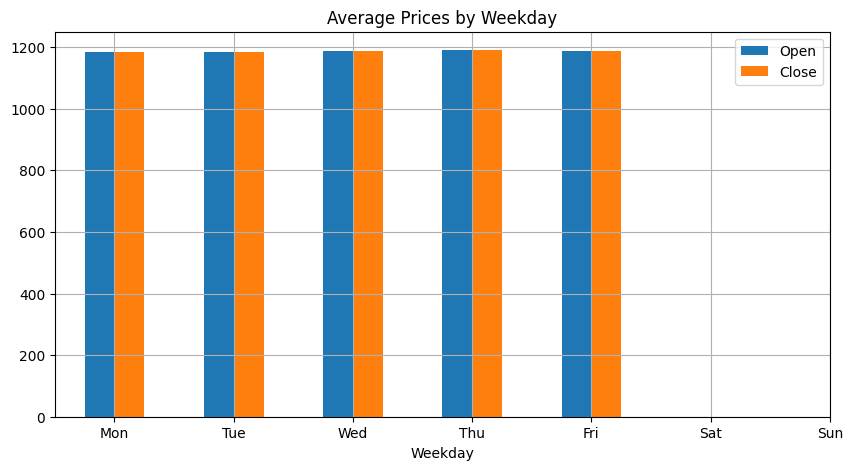

/home/jana/TM/LLMinStockPrediction/src/visualizations.py:60: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



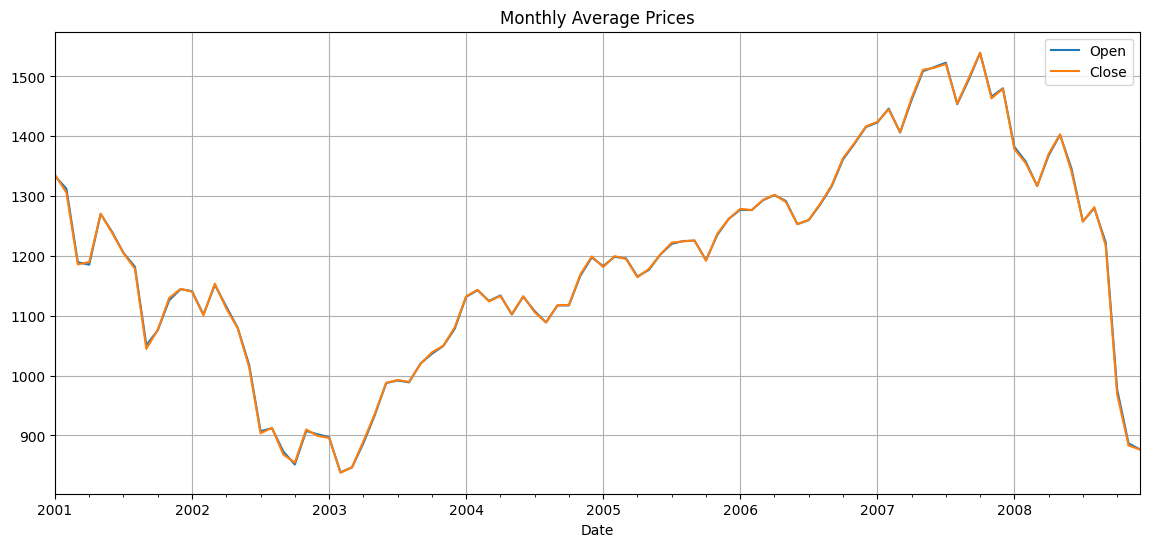

In [17]:
plot_seasonality(df)

In [ ]:
df.drop(columns=['Daily Return', 'Rolling Mean', 'Rolling Std', 'Weekday'], inplace=True)